In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})


def errorfill(ax, x, y, yerr, color=None, alpha_fill=0.3, alpha_line=1, lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize)

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.yaxis.set_tick_params(which='minor', left=False)
    ax.set_yticklabels([])


In [3]:
from scalable_gps.wandb_utils import load_runs_from_sweep
import numpy as np
import os

def get_sweep_id_and_splits(dataset):
    return {'housing': ('ue92u9zs', [1, 2, 3, 4, 5, 7, 8, 9]),
            'pol': ('7l9umiit', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
            'elevators': ('tbt2uoyh', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
            'bike': ('iykb58j8', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
            }[dataset]

# datasets = ['protein']
datasets = ['housing', 'pol', 'elevators', 'bike']

n_steps = 500
config_keys = ['dataset_config.split', 'sampling_config.loss_objective']
metric_keys = ['sampling/grad_var_mean']

results_path = "./grad_var.npy"

if os.path.isfile(results_path):
    results = np.load(results_path, allow_pickle=True).item()
else:
    results = dict()

for dataset in datasets:
    if dataset in results.keys():
        print(f"Results for '{dataset}' already exist.")
        continue
    sweep_id, splits = get_sweep_id_and_splits(dataset)
    n_splits = len(splits)
    results[dataset] = np.zeros((n_splits, 3, n_steps))
    
    print(f"Downloading results for {dataset}")
    configs_and_metrics = load_runs_from_sweep(sweep_id, config_keys, metric_keys)

    for (configs, metrics) in configs_and_metrics:
        split = configs['dataset_config.split']
        if split not in splits:
            continue
        print(dataset, split)
        split_idx = splits.index(split)
        loss_idx = configs['sampling_config.loss_objective'] - 1
        results[dataset][split_idx, loss_idx] = metrics['sampling/grad_var_mean']
    np.save(results_path, results)

Results for 'housing' already exist.
Results for 'pol' already exist.
Results for 'elevators' already exist.
Results for 'bike' already exist.


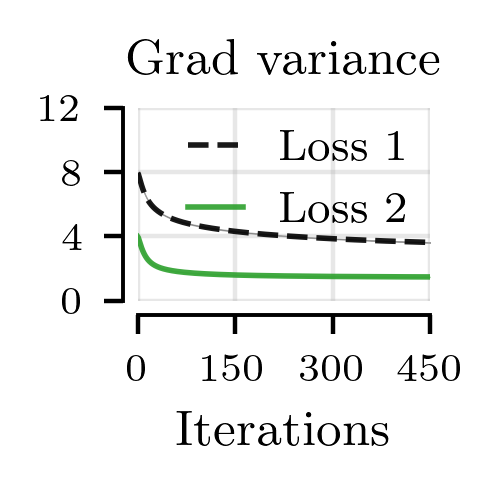

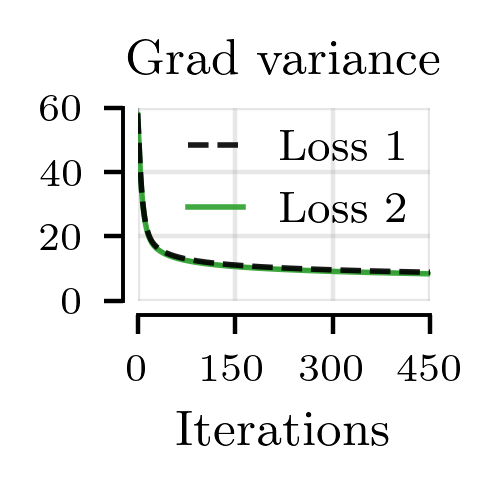

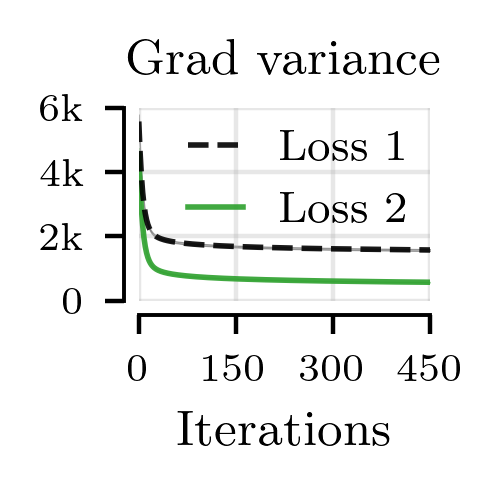

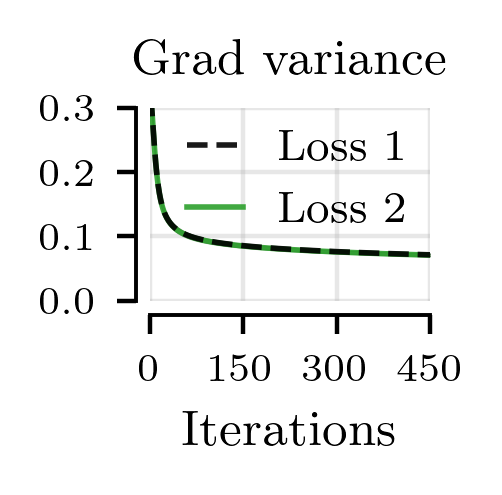

In [4]:
def get_color(loss_idx):
    return ['k', 'tab:green', 'tab:red'][loss_idx]

def get_y_ticks(dataset):
    if dataset == 'housing':
        return [0, 4, 8, 12], None
    elif dataset == 'pol':
        return [0, 20, 40, 60], None
    elif dataset == 'elevators':
        return [0, 2000, 4000, 6000], ["0", "2k", "4k", "6k"]
    elif dataset == 'bike':
        return [0, 0.1, 0.2, 0.3], None

alpha_line = 0.9
x_ticks = [0, 150, 300, 450]

# legend_handles = []
# for model in models:
#     for override_noise_idx in [0, 1]:
#         c = get_color(model, override_noise_idx)
#         legend_handles.append(Line2D([], [], color=c, label=get_label(model, override_noise_idx)))

for dataset in datasets:
# for dataset in ['housing']:
    fig = plt.figure(dpi=400, figsize=[0.24 * text_width, 0.15 * text_height])
    ax = fig.add_subplot(111)
    ax.set_title("Grad variance")
    ax.set_xlabel("Iterations")
    ax.grid(alpha=0.3)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines['bottom'].set_position(('axes', -0.075))
    ax.spines['left'].set_position(('axes', -0.05))
    ax.set_xlim(np.min(x_ticks), np.max(x_ticks))
    ax.set_xticks(x_ticks)

    y_ticks, y_ticklabels = get_y_ticks(dataset)
    ax.set_ylim(np.min(y_ticks), np.max(y_ticks))
    ax.set_yticks(y_ticks)
    if y_ticklabels is not None:
        ax.set_yticklabels(y_ticklabels)

    n_splits = results[dataset].shape[0]
    mean = np.mean(results[dataset], axis=0)
    err = np.std(results[dataset], axis=0) / np.sqrt(n_splits)

    for loss_idx in [1, 0]:
        ls = '-' if loss_idx else '--'
        c = get_color(loss_idx)
        errorfill(ax, range(n_steps), mean[loss_idx], err[loss_idx], color=c, alpha_line=alpha_line, linestyle=ls,
                  label=f"Loss {loss_idx + 1}")

    # legend_handles = []
    # c = get_color(model, override_noise_idx)
    # legend_handles.append(Line2D([], [], color=c, label=label, linestyle=ls))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=8, frameon=False, handlelength=1.25, borderpad=0.)

    fig.tight_layout(w_pad=0.5, h_pad=0.2)
    fig.savefig(f"../../figures/grad_var_{dataset}.pdf", bbox_inches='tight', pad_inches=0.01)
    fig.savefig(f"../../figures/grad_var_{dataset}.png", bbox_inches='tight', pad_inches=0.01)